# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 18
### <center> Yoshihiro Shirai

# Convolutional Neural Networks

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 14: convolutional neural networks.

# 0. Overview of the lecture

- We introduce convolutional neural networks (CNNs). Specifically, we introduce their building blocks, two new layers: the convolutional layer and pooling layer.

- Then we provide an example of CNN architectures and fit a CNN to MNIST and Fashion MNIST datasets.

# 1. Convolutional neural networks (CNN)

- RNNs are used for time series data, to take temporal dependence into account. Analogously, convolutional neural networks (CNNs) are neural networks for spatial data, to take spatial dependence into account.

- Some tasks that are almost effortless for humans, are very difficult for computers. Speech recognition and many visual tasks fall into this category.

- One of the main reasons for the popularity of neural networks is their success in achieving superhuman performance on some complex visual tasks and natural language processing (NLP). This success is mainly attributed to CNNs.

- Applications of CNNs include image classification, creating bounding boxes for objects, object classification, self-driving cars.

- CNNs are loosely designed based on the structure of the visual cortex of the brain.

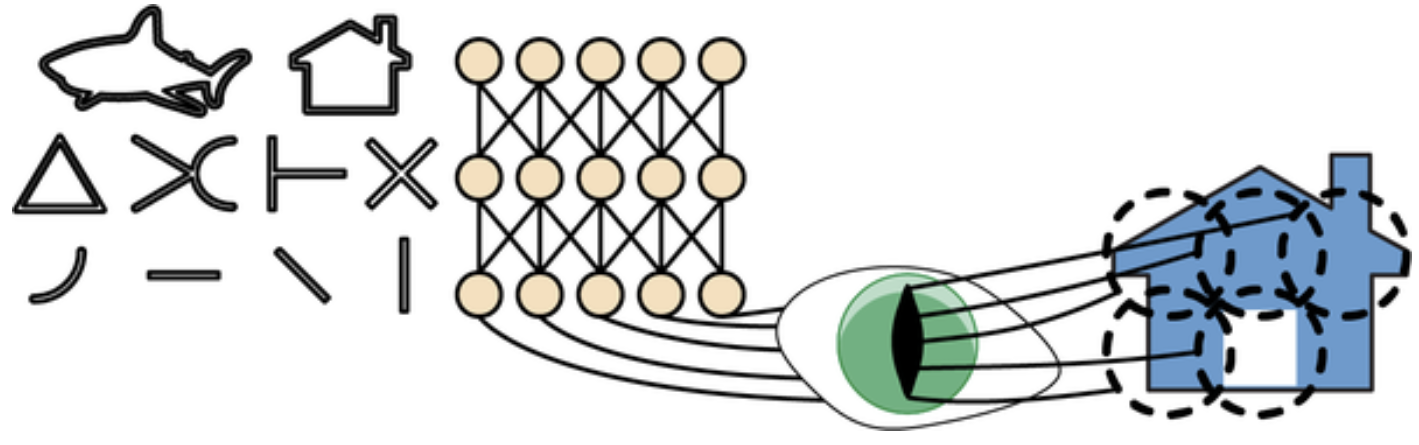

In [1]:
from IPython.display import Image
Image("Figs/visual_cortex.png",width=700)

- Many neurons in the visual cortex only react to visual stimuli located in certain parts of the visual field, called the **local receptive field** of that neuron.

- The receptive field of neurons may be different or partially overlap. But the receptive fields of different neurons add up to the whole visual field.

- Some neurons react only to certain patterns in their receptive field, say, horizontal lines. Some neurons have the same receptive field but react to different patterns.

- Some neurons have larger receptive fields than other neurons and seem to react to more complicated patterns that are combinations of lower level patterns. This observation implies that these neurons receive the output of lower level neighboring neurons.

- These observations inspired a model called **neocognitron** in 1980s which eventually evolved into CNNs.

- An important milestone was the invention of **LeNet-5** architecture in the late 1990s, which is widely used by banks to recognize handwritten check numbers.

- CNNs have some building blocks that we have already studied (such as fully connected layers and logistic activation). They, however, have two new building blocks that we need to introduce: **convolutional layers** and **pooling layers**.

- In brief, a CNN works like this: the convolutional layers filter the image to produce images with high-level features, then the pooling layer downsamples those images to reduce the computation expense. This is repeated several times, which is in effect extracting low-level features from the high-level features. Then these are passed into a fully connected DNN.

- You may wonder what is the problem with using simple fully connected networks (such as the ones we have been training on fashion MNIST) for image processing?

- Firstly, fully connected networks do not explicitly take spatial dependence into account. Reducing the input into a vector of pixel values, any permutation of the input vector would be an equivalent network.

- In contrast, in CNNs, the input is the image itself and the convolutional layer takes spatial dependence into account.

- Secondly, fully connected networks easily become intractable for even moderately size images.

- Consider processing a 100-by-100 pixel image (in comparison a 1080 HDTV image is 1920-by-1080), which is 10,000 pixels.

- A fully connected single layer ANN with 1000 neurons (which is not going to capture enough of the input information) will have 10,000,000 connection weights. This is just the first layer.

- As we will see, CNNs circumvent this issue by effectively using **partially connected** layers and also **weight sharing**.

# 2. Convolutional layer

- The convolutional layer is the most important part of a CNN.

- A neuron in a convolutional layer is only partially connected to a lower level layer (e.g. the input layer or another convolutional layer). So, each neuron has a receptive field, like biological neurons in the visual cortex.

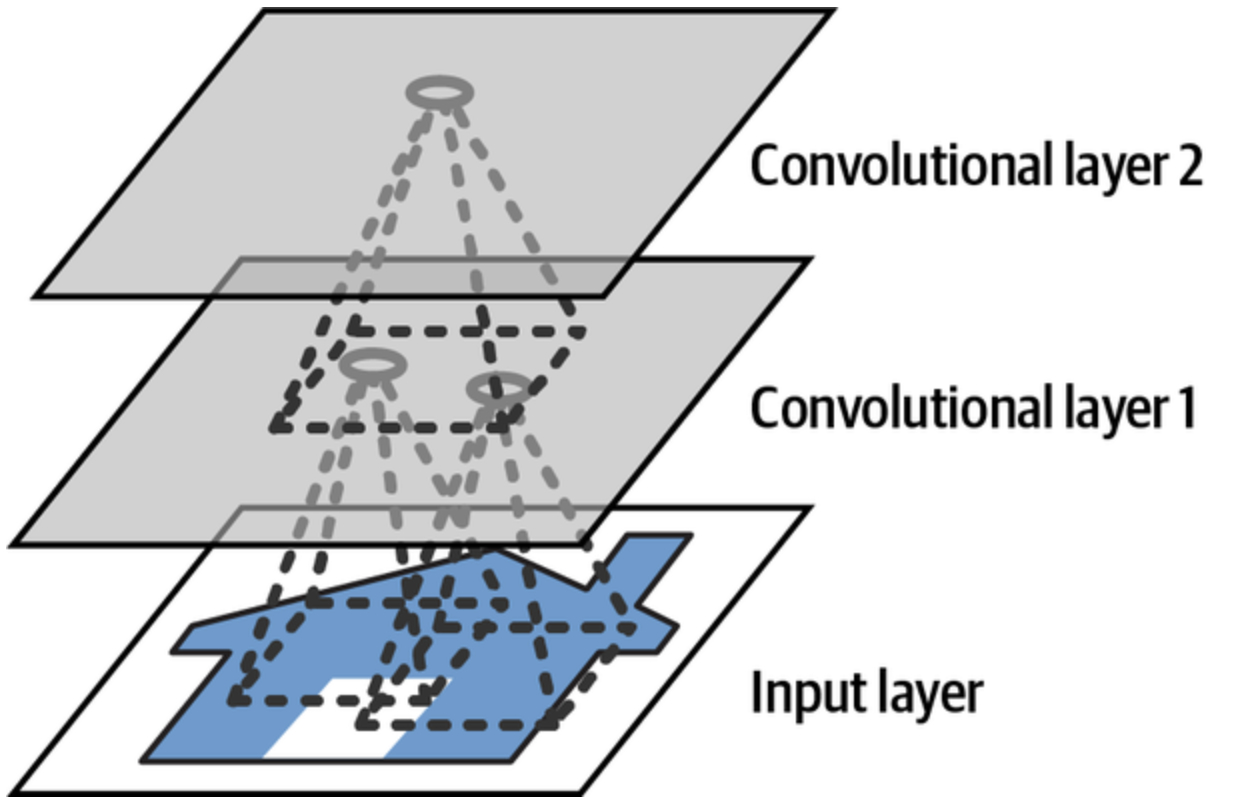

In [2]:
Image("Figs/CNN1.png",width=600)

- We assume the input is a 2D image, and we do not flatten it to a 1D vector.

- The $(i,j)$-th neuron in a layer is connected to $(i',j')$-th neurons of the previous layer where
$$i'\in\{i,...,i+f_h-1\}, \quad j'\in \{j,...,j+f_w-1\}$$

- Here, $f_w$ and $f_h$ are, respectively, the height and width of the receptive field.

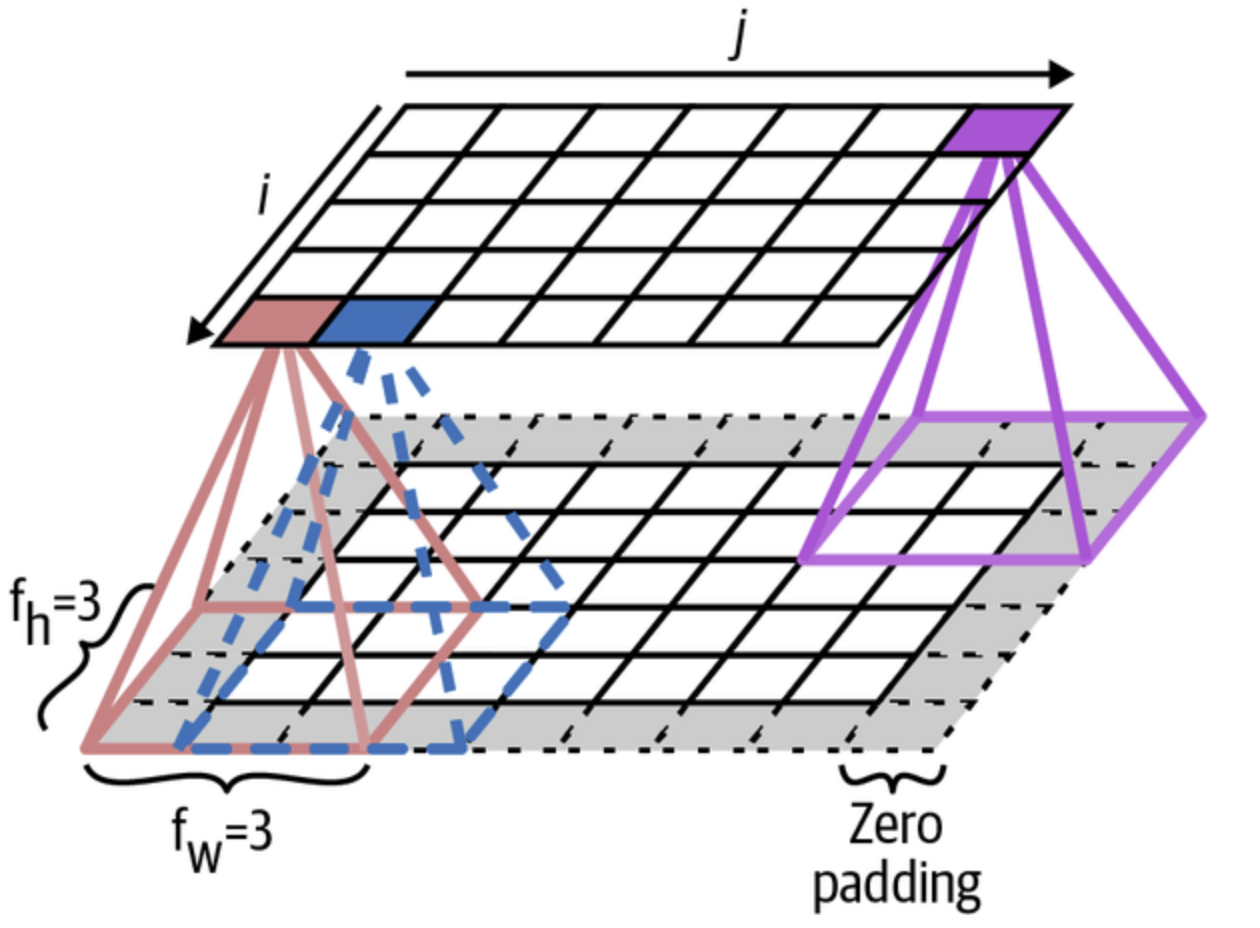

In [3]:
Image("Figs/CNN2.png",width=600)

- Using the indexing above will cause a layer to be smaller than its previous layer.

- For consecutive layers to have the same size, it is customary to add a margin of neurons with zero output, called $zero padding$, around the lower layer.

- Sometimes, we want to connect a larger (e.g. input) layer to a smaller higher level layer. We can achieve this by "spacing out" the receptive fields, making the overlaps between neighboring receptive fields smaller.

- The corresponding indexing is as follows. Connect the $(i,j)$-th neuron of a higher layer to $(i',j')$-th neurons of lower layers where
$$i'\in\{i s_h,...,i s_h+f_h-1\} \quad j'\in\{j s_w,...,j s_w+f_h-1\}$$

- $s_h$ and $s_w$ are called the horizontal and vertical **strides**.

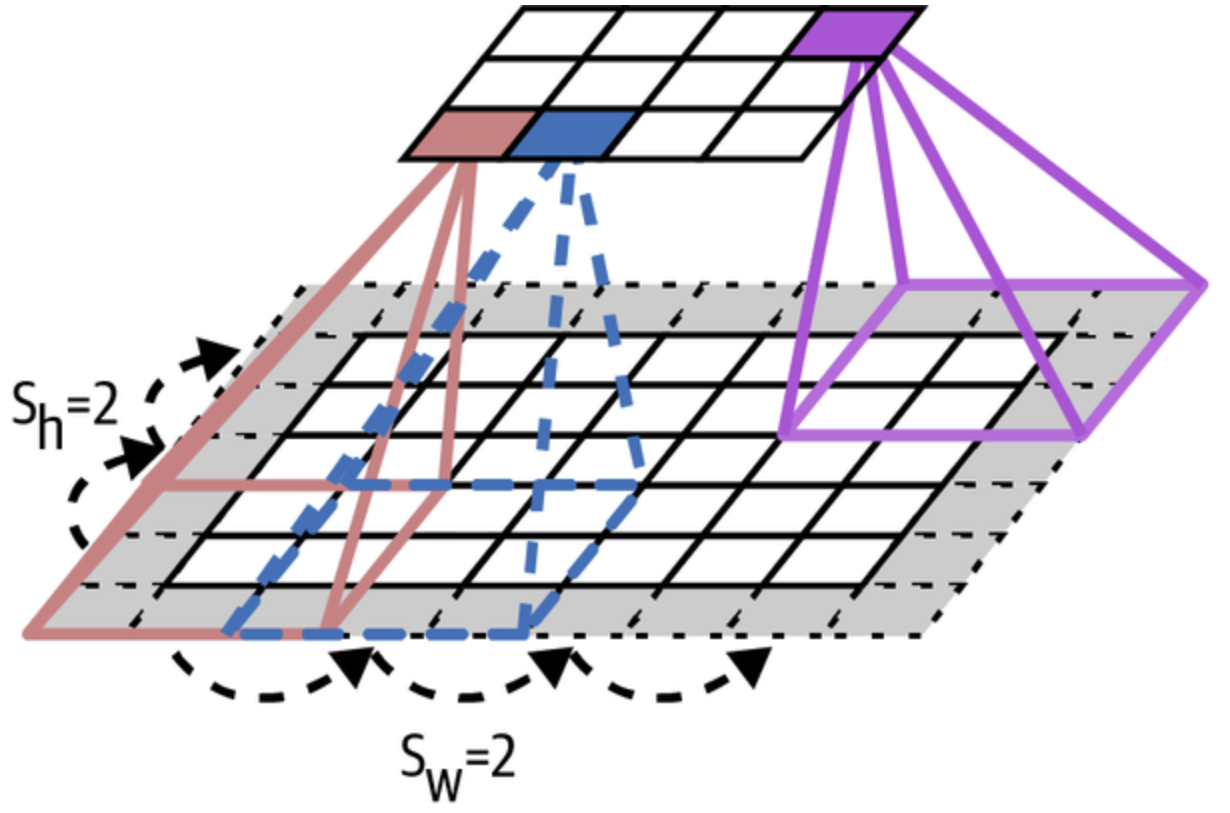

In [4]:
Image("Figs/CNN3.png",width=600)

## 2.1. Filters and feature maps

- As you have noticed above, convolutional layers are not fully connected to their lower layer by using receptive fields. This will reduce the number of their parameters (i.e. the connection weights).

- Another way that convolutional layers reduce the number of their parameters is through weight sharing.

- Consider a neuron in a convolutional layer. It is connected to each neuron in its receptive field. So, we can represent its input connection weight by a $f_h$-by-$f_w$ matrix.

- A filter (also called a convolutional kernel or, simply, a kernel) is a set of weights and a bias term for a single neuron, that is, an $f_h$-by-$f_w$ matrix of weights and a constant bias.

- A feature map is a set of neurons of a convolutional layer that uses the same filter (that is, they share the same feature weights).

- The following picture shows the feature map corresponding to two different filters.

- The horizontal filter (the center row of the filter has positive weights and all other elements are zero) highlights horizontal lines in the image.

- The vertical filter (the center column of the filter has positive weights and all other elements are zero) highlights vertical lines in the image.

- Note that we don't choose the filter. It is something that is determined during the training of a CNN. It may not turn out to be a vertical or horizontal filter.

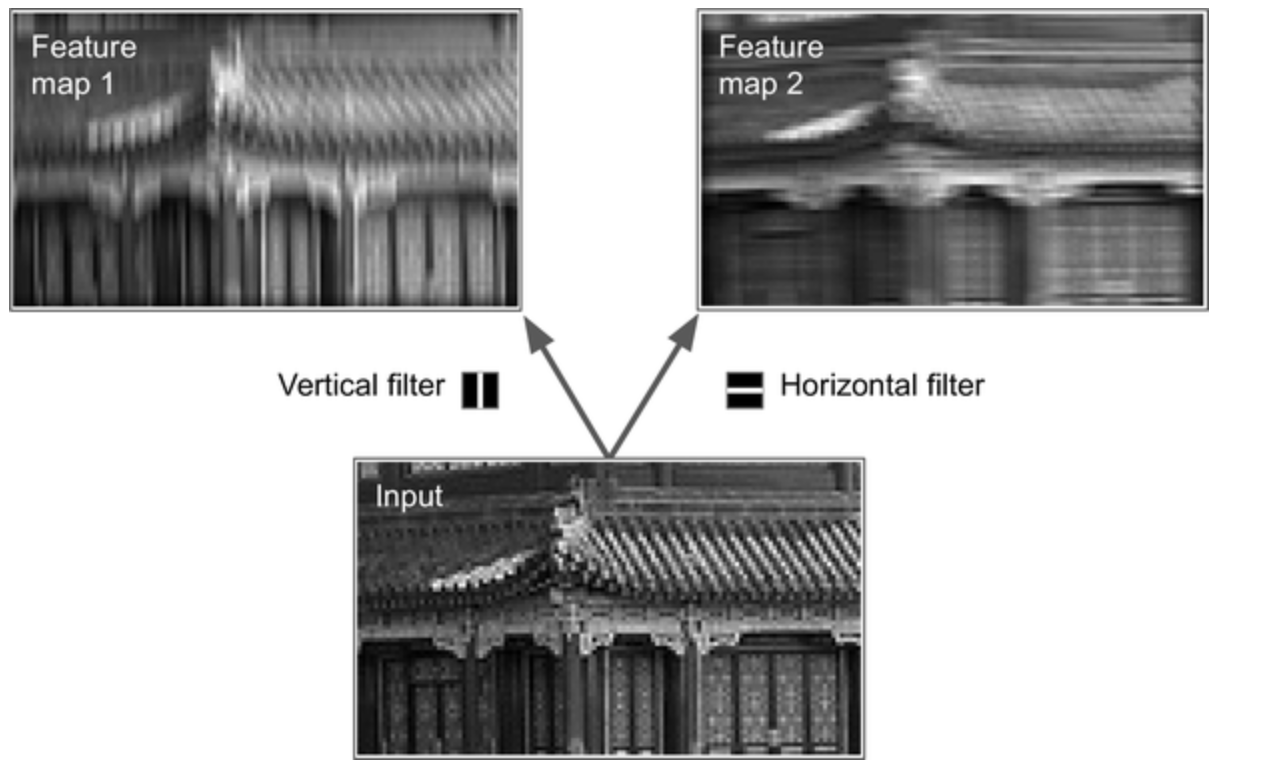

In [5]:
Image("Figs/filter.png",width=600)

- A convolutional layer usually has more than one filter. Each filter has a corresponding feature map.

- As such, it is easier to represent convolutional layers as a set of feature maps stacked on top of each other. Two feature maps in the same convolutional layer are not connected to each other, however.

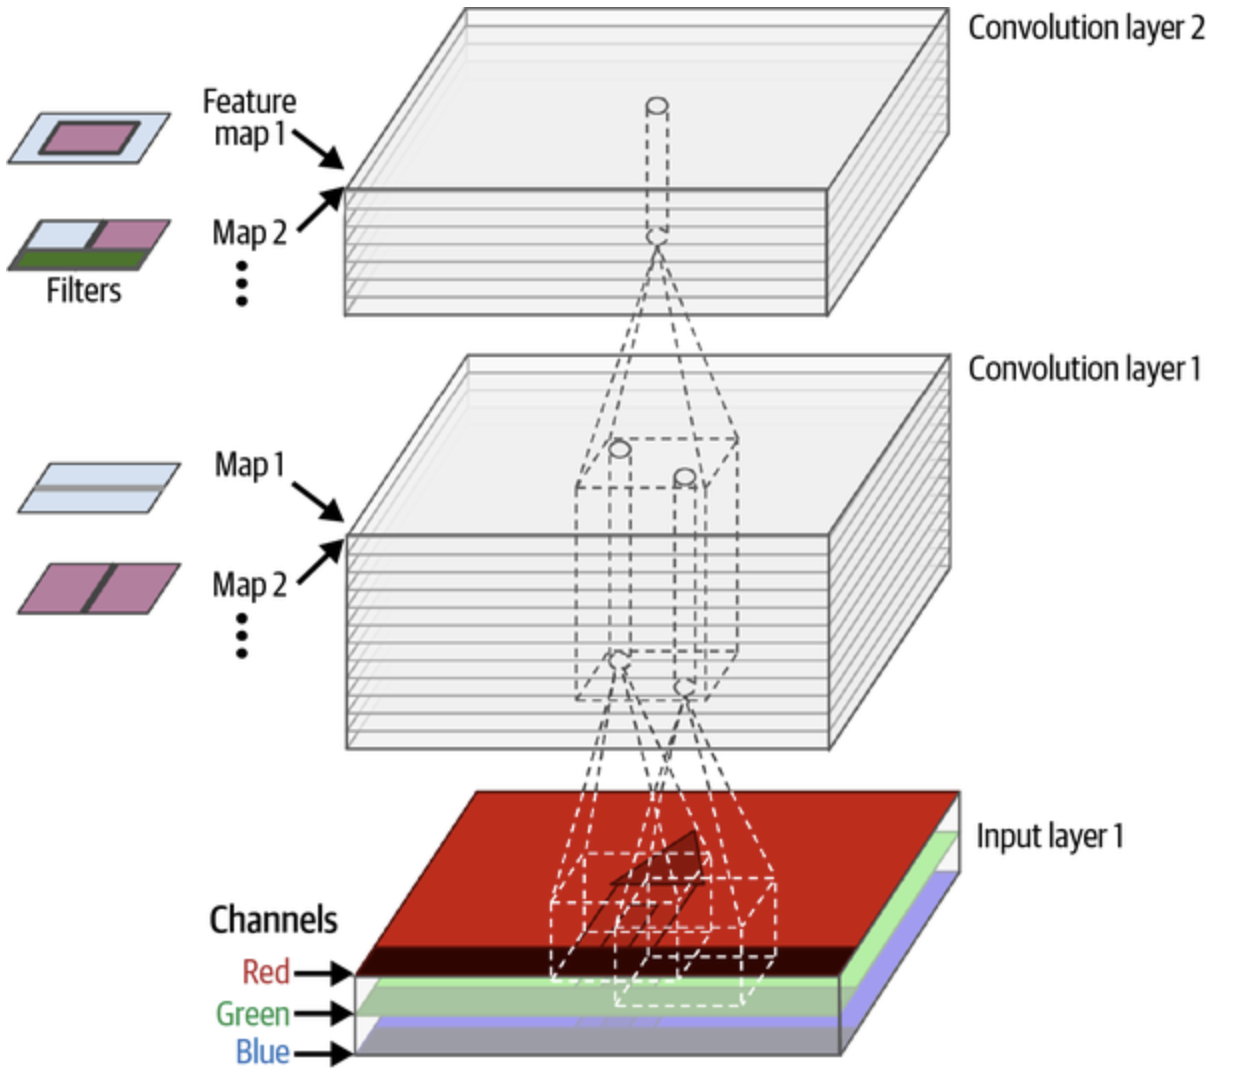

In [6]:
Image("Figs/CNN4.png",width=600)

- Neurons **in the same feature map** share the same weight and bias (i.e. the filter). They are connected to a different set of neurons in the lower convolutional layer. That is, they have a different receptive field.

- If a convolutional layer is connected to another convolutional layer, the receptive field of a neuron in the higher layer extends through all the feature maps of the lower layer. Therefore, the filter is a 3D array of size $f_h$-by-$f_w$-by-$K$, where $K$ is the number of feature maps of the lower layer, and the weights may be different for each of the $K$ feature maps of the lower layer.

- The $(i,j)$-th neurons of two different feature maps (of the same convolutional layer) are connected to the same neurons of the previous layer, that is, they have the same receptive field. They, however, have different filters (weight and biases.)

- The inputs of CNNs usually have multiple entries per pixel. For example, a color image has 3 inputs per pixel: the amount of red, green, and blue.

- For input layers, these are called channels.

- So, an RGB image has three channels. A grayscale image has only one channel. More advanced images (e.g. satellite) can have more than 3 channels (such as infrared).

- The connections between the first convolutional layer and the input layer is the same as the connections between any two convolutional layers. Specifically, a filter in the first convolutional layer is a $f_h$-by-$f_w$-by-$C$ 3D array, where $C$ is the number of input channels.

- In other words, Convolution Layer 1 considers the input channels as feature maps, in the same way that Convolution Layer 2 considers the feature maps of Convolution Layer 1.

- Let us summarize the discussion above by showing the formula for the output of a neuron in a convolutional layer.

- Recall that for a fully connected layer, we simply represent the output of neuron $i$ as
$$\phi\left(b_i+\sum_{j=1}^Nw_{i,j}x_j\right)$$

- Here, $N$ is number of neurons in the previous layer and $\phi(\cdot)$ is an activation function (e.g. ReLU).

- For a convolutional layer, we need more notation, but the general structure is the same.

- Let:
    - $f_h$ and $f_w$ be the height and width of the receptive field.
    - $s_h$ and $s_w$ be the vertical and horizontal strides.
    - $K$ be the number of feature maps in the previous layer (or number of channels if the previous layer is the input layer).

- Then, the output of the $(i,j)$-th neuron in the $k$-th feature map of the current convolution layer is $\phi(z_{i,j,k})$, where $\phi(\cdot)$ is the activation function (usually ReLU) and
$$z_{i,j,k} = b_k+\sum_{i'=0}^{f_h-1}\sum_{j'=0}^{f_w-1}\sum_{k'=0}^{K-1} w_{i'.j',k',k}\times x_{is_h+i',js_w+j',k'}$$

- Here, $w_{i',j',k',k}$ is the $(i',j',k')$-th element of the $k$-th feature of current convolutional layer (the $(i',j')$ index is relative to the neuron;s receptive field).

- $x_{i,j,k'}$ is the output of the $(i,j)$-th element of the $k'$-th feature map in the previous layer.

- $b_k$ is the bias term for the $k$-th feature map in the current convolutional layer

- Let us see how to define a convolutional layer in Keras.

- To create a convolution layer that accepts 2D images (as we discussed above), use `tf.keras.layers.Conv2D`


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) # Supressing save information/warnings

In [8]:
tf.keras.layers.Conv2D(filters=32, kernel_size=(3,2), strides=(2,1),
                    activation="relu", padding="SAME")

<Conv2D name=conv2d, built=False>

- filters is the number of filters (i.e. feature maps).

- `kernel_size` (respectively, `strides`) is the kernel height and width (respectively, vertical and horizontal strides). If you pass on a number (instead of a tuple), it will be assumed that the dimensions are equal. That is, `kernel_size=3` is the same as `kernel_size=(3,3)`.

- activation is the activation function to use. You can also use other layer hyperparameters such as kernel_initializer or kernel_regularizer.

- `padding="SAME"` results in the convolutional layer padding the input with 0s such that the dimension of the layer is the dimension of the previous layer divided by the strides, then rounded up. Example, if the width of the previous layer is 12 and the horizontal stride is $s_w=5$, then `padding="SAME"` results in the width of the layer being $f_w=\text{ceiling}(12/5)=3$. If the stride is 1, then the input and output have the same dimension.

- `padding="VALID"` results in the convolutional layer not using padding and instead ignoring some neurons from the lower layer as shown below.

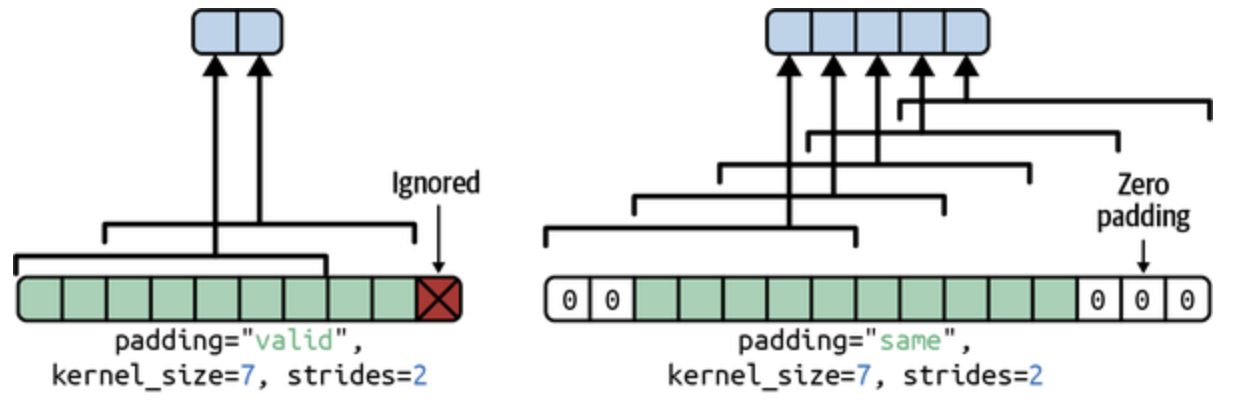

In [9]:
Image("Figs/padding.png",width=600)

- If your convolutional layer is the first layer of the network, you can use two additional argument to specify the type of input, namely, `data_format` and `input_shape`

- For example, the following code, if given as the first layer, defines a convolutional layer with 32 feature maps, 3-by-2 filters, 2-by-1 strides that accepts 28-by-28 grayscale images and also adds zero padding around the inputs.

In [ ]:
tf.keras.layers.Conv2D(filters=32, kernel_size=(3,2), strides=(3,5),
                    activation="relu", padding="SAME",
                    data_format="channels_last", input_shape=(28, 28, 1))

- The input is usually a 4D array with dimensions corresponding to `batch` (number of observations), `height` (the vertical positions of the pixel), `width` (the horizontal position of the pixel), `channels` (which input channel).

- `Using data_format="channels_last"` assumes the input is `(batch, height, width, channels)`. Using `data_format="channels_first"` assumes the input is `(batch, channels, height, width)`. `"channels_last"` is the default value.

- `input_shape=(height, width, channels)` specifies the dimensions of the input.

- Note that 1-dimensional convolutional layers (`tf.keras.layers.Conv1D` in Keras) are useful for time series data. This slides several kernels across the time series to help detect patterns. The convolution layer can be inserted before the RNN layers and may improve results.

# 3. Pooling layer

- A **pooling layer** is a simple layer with the sole purpose of aggregating an input to reduce its dimensionality, hence reducing the computational load, memory usage, and overfitting.

- Each neuron in a pooling layer has a receptive field, just like the usual convolutional neurons. You should determine the receptive field's dimension, stride, and padding.

- Unlike convolutional layers, however, pooling layers do not have any kernel (weight and bias). Each neuron applies a simple aggregation over its receptive field.

- Pooling layers usually act independently on feature maps. So, a pooling layer has the same depth (i.e. number of feature maps) as their previous layer.

- The main aggregation functions are average and max. Max-pooling is preferred as it leads to better performance (one reason is that max pooling preserves the strongest input and gets rid of weak, and possibly meaningless, inputs).

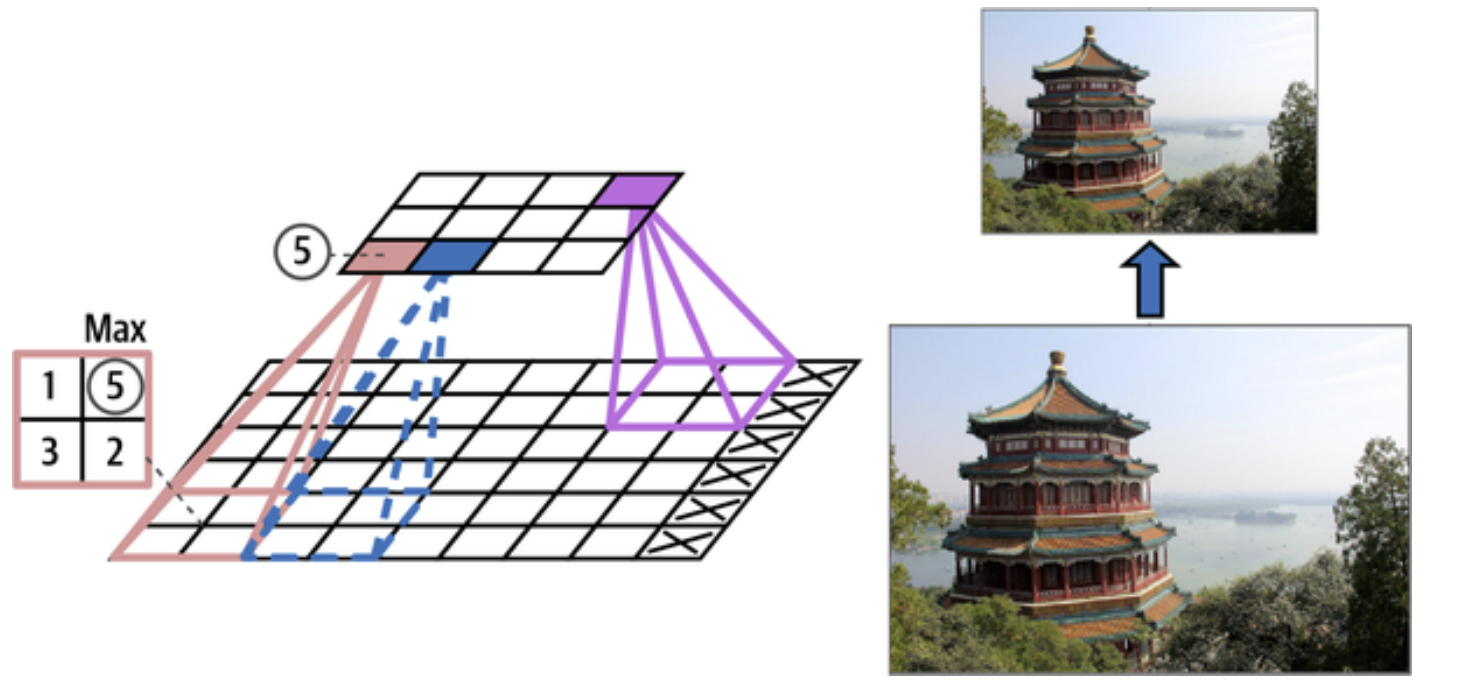

In [11]:
Image("Figs/pooling.png",width=700)

- Pooling layers introduces some translation invariance. This invariance can be a desirable feature, for example in a classification task where the class should not depend on where the object is in the image.

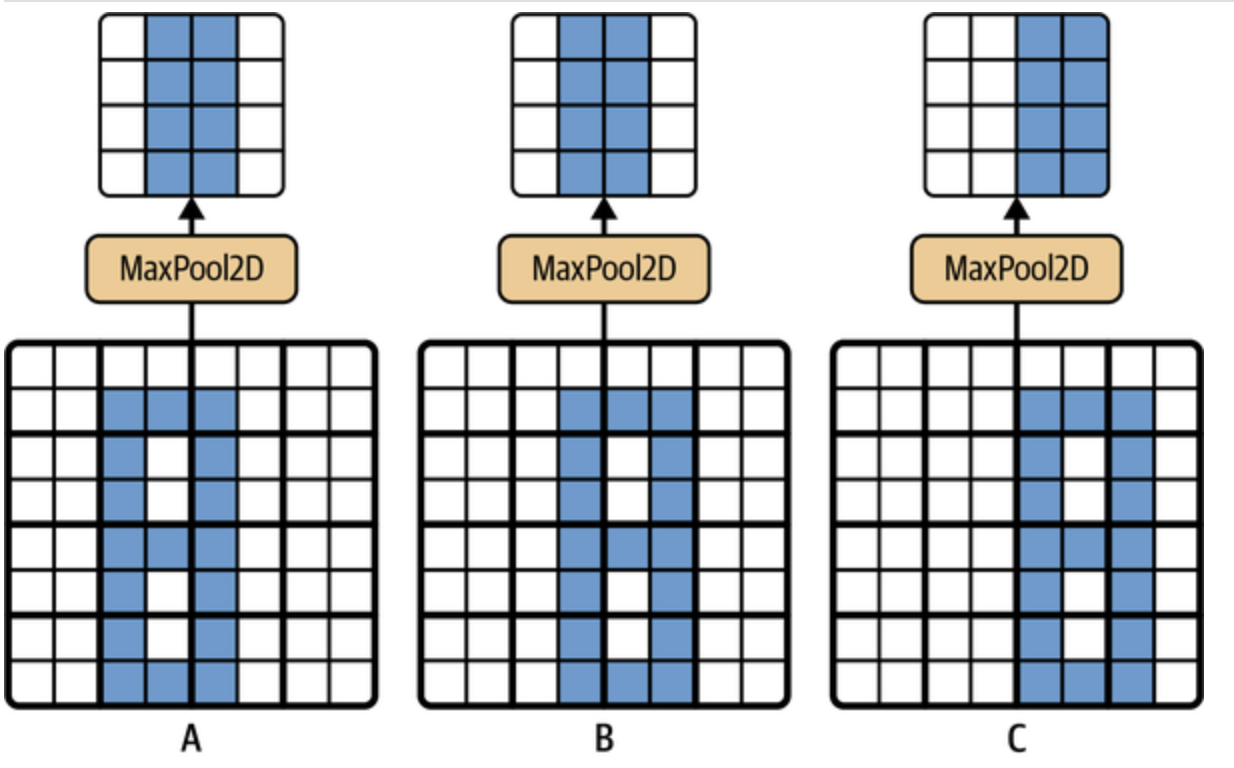

In [12]:
Image("Figs/invariance.png",width=600)

- As we mentioned earlier, pooling is usually done across the spatial dimensions (i.e. in each feature map of the previous layer). However, it is possible to pool across the depth dimension. For example we can take the max of $(i,j)$-th neurons across different feature maps.

- By using this technique, the neural network can learn to be invariant to more complicated transformations, such as rotations, thickness, brightness, color, etc.

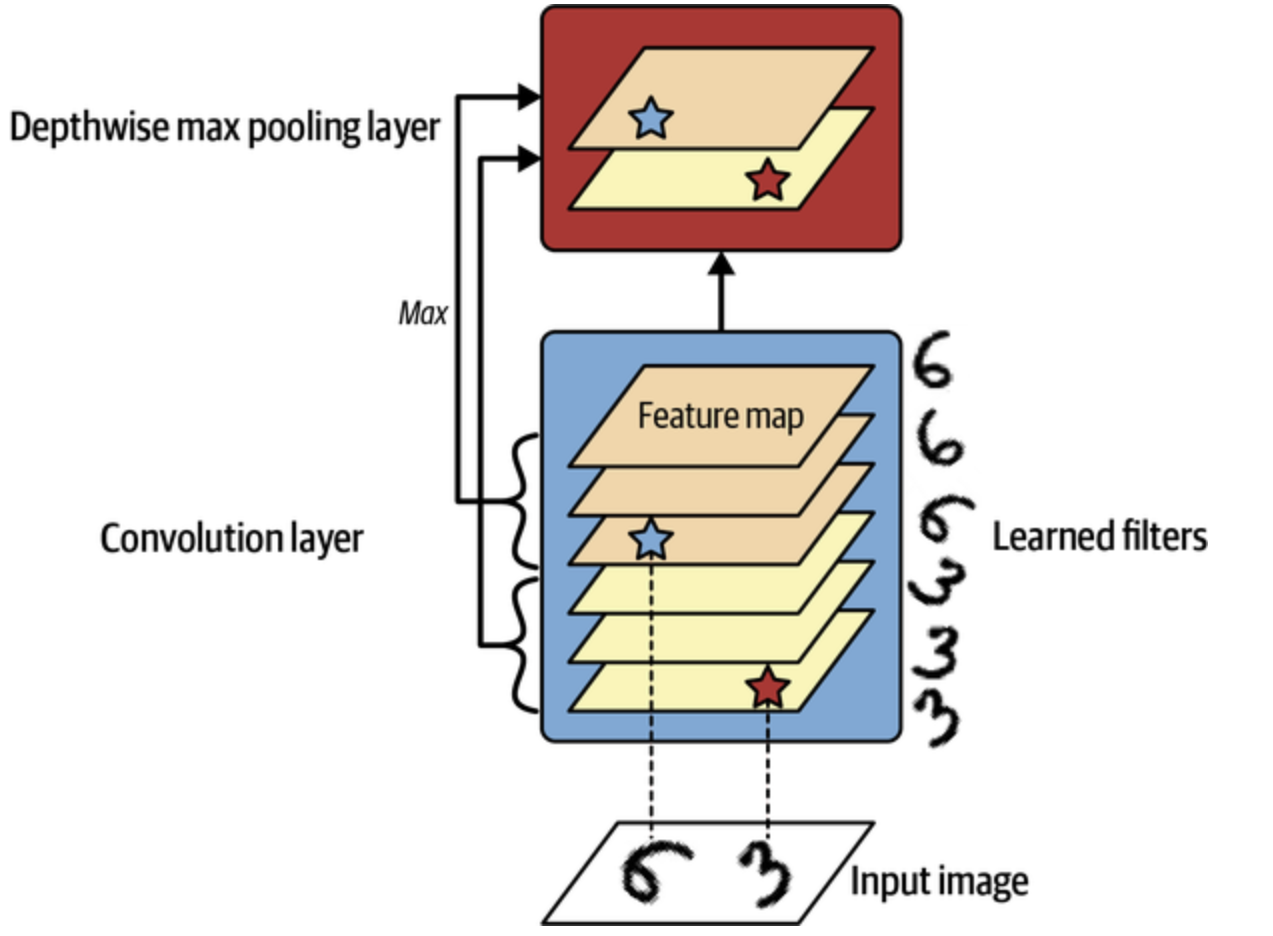

In [13]:
Image("Figs/depthpooling.png",width=600)

- Creating a spatial pooling layer is easy in Keras by using the `tf.keras.layers.MaxPool2D` or `tf.keras.layers.AvgPool2D`

- The following code creates a max-pooling layer, with a 2-by-2 receptive field and a 2-by-2 stride, that does not add zero padding.

In [14]:
tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding="VALID")

<MaxPooling2D name=max_pooling2d, built=False>

- If you pass a single number instead of a tuple to strides and `pool_size`, it will be assumed that both dimensions are equal to that number. Furthermore, the default strides are `pool_size` and the default padding is `"VALID"`. Therefore, the previous line can also be written as follows:

In [15]:
tf.keras.layers.MaxPool2D(pool_size=2)

<MaxPooling2D name=max_pooling2d_1, built=False>

- Depth-wise pooling is a little bit more complicated, as Keras does not provide it, but it can be created using a Tensorflow function and a `tf.keras.layers.Lambda` layer.

In [16]:
depth_pool = tf.keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))

- `ksize` and `strides` are the dimension and strides of the receptive field. The first three values of each should be 1: this indicates that the kernel size and stride along the batch, height, and width dimensions should be 1. The last value is the kernel size and stride you want along the depth dimension

- An alternative implementation using `tf.reduce_max` that works on the GPU is given in the textbook.

# 4. CNN Architecture

- We now have the necessary building blocks to build a CNN. Here is a typical CNN architecture:

- Start with one or more convolutional layers usually with ReLU activation, followed by a pooling layer. Then, we have other convolutional layers with ReLU, followed by a pooling layer. The effect of the convolution and pooling is essentially to extract features.

- This is fed into the top layers, which are fully connected layers. The last layer is, of course, the output layer (e.g. softmax for classification).

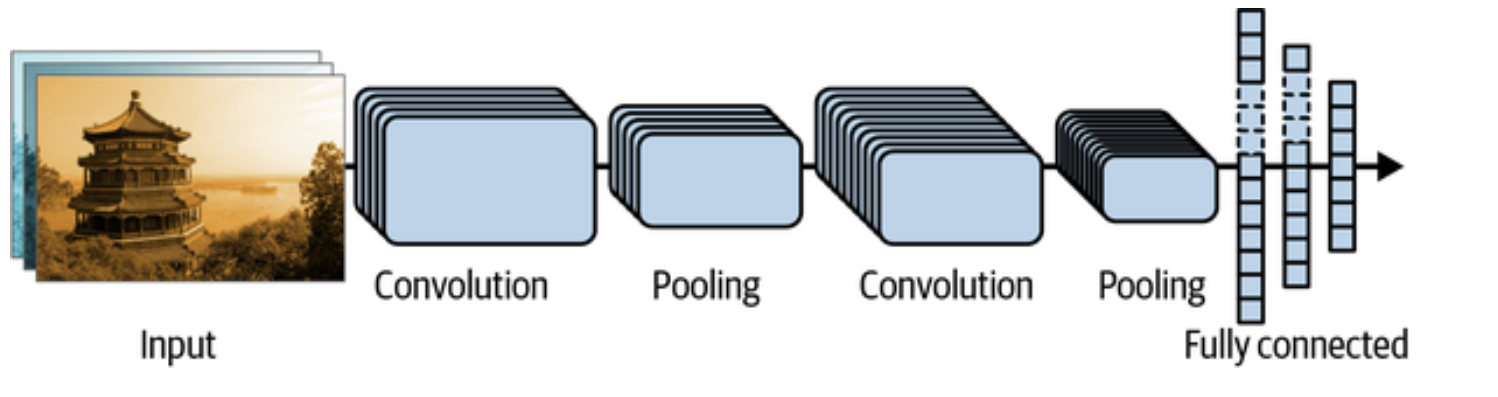

In [17]:
Image("Figs/architecture.png",width=700)

- Lower convolutional layers have larger kernel sizes but also fewer feature maps. Higher convolutional layers use smaller kernel sizes but are deeper (more feature maps).

- The idea is that the lower convolutional layers are there to find simple patterns in the images (e.g. lines, curves, edges, etc.). So, they need fewer feature maps but large kernel sizes to contain as much information as possible from the inputs.

- Higher convolutional layers learn to detect more complicated patterns based on the simple features (e.g. triangles, squares, eyes, faces, etc.). So, they need more feature maps, with smaller kernel sizes.

- It is a common mistake to use larger kernel sizes. Instead of using a convolutional layer with 5-by-5 kernels, you should use 2 convolutional layers with 3-by-3 kernels. The latter choice will be easier to train and will perform better.

- The only exception to this rule is the first convolutional layer. It usually uses large filters (e.g. 7-by-7), so that it passes along enough simple features to higher level layers.

- Modern CNN architectures use many layers. For example, LeNet-5, VGGNet, etc. The figure below shows the ResNet architecture. Variations of this architecture, with 34 or even 152 layers, have shown great performance in various ML tasks and competitions.

- There are many more CNN architectures, and research in this field is still ongoing.

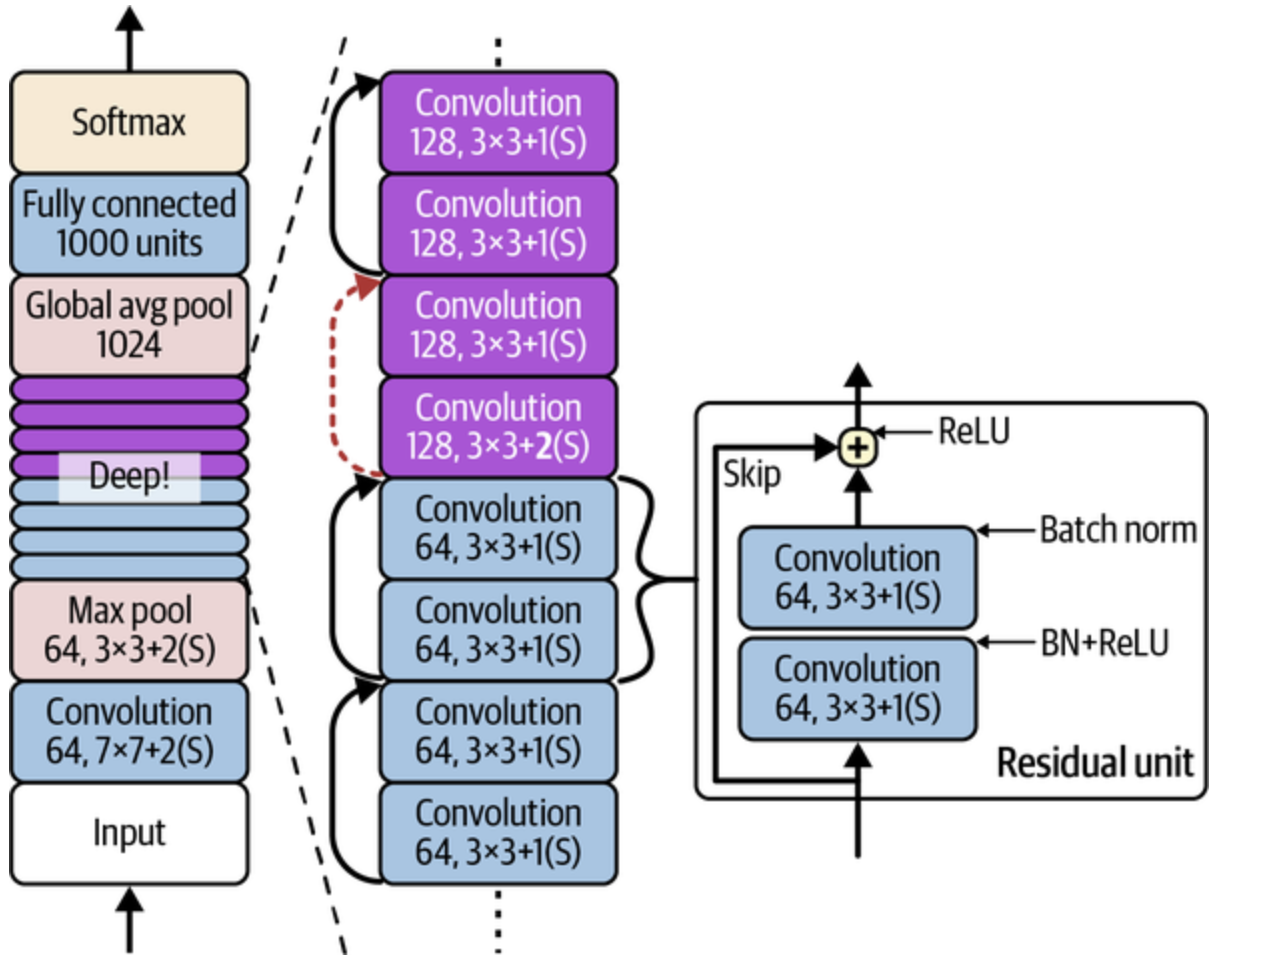

In [18]:
Image("Figs/resnet.png",width=600)

- In general, you don't have to implement standard models like ResNet manually, since pretrained networks are readily available with a single line of code in the Keras package. For example, you can load the ResNet-50 model, pretrained on ImageNet, a database of millions of labelled images, using tf.keras.applications.ResNet50(weights="imagenet").

- However, you do need to convert your data into the input that ResNet-50 expects, which is 224-by-224 pixel images.

- If you want to build an image classifier but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model like ResNet-50 by applying transfer learning.

# 5 Training a CNN on MNIST and Fashion MNIST

- Let us train a simple CNN for MNIST and fashion MNIST. Let us start with MNIST.

In [19]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [20]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

- Since many convolutional layers expect channels in the input, we created a "channel" dimension using np.expand_dims this is the same as X_train[..., np.newaxis] for instance. Note, however, that there is only 1 channel since the image is grayscale.

In [21]:
X_train.shape

(55000, 28, 28, 1)

- Next, we create a rather simple CNN. It is not the state-of-the-art architecture. But, as we will see, it has a good performance on MNIST and fashion MNIST.

- This CNN broadly follows the architecture outlined above.

In [22]:
from functools import partial

reset_session()
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

- Let us train the model. Each epoch takes several minutes. Note that we get 98% validation accuracy after the first epoch.

In [23]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 91s 51ms/step - accuracy: 0.7435 - loss: 0.7750 - val_accuracy: 0.9904 - val_loss: 0.0380
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 92s 53ms/step - accuracy: 0.9673 - loss: 0.1378 - val_accuracy: 0.9880 - val_loss: 0.0502
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 90s 52ms/step - accuracy: 0.9782 - loss: 0.0930 - val_accuracy: 0.9918 - val_loss: 0.0384
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 94s 55ms/step - accuracy: 0.9843 - loss: 0.0690 - val_accuracy: 0.9918 - val_loss: 0.0377
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 104s 61ms/step - accuracy: 0.9863 - loss: 0.0603 - val_accuracy: 0.9900 - val_loss: 0.0349
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 90s 53ms/step - accuracy: 0.9871 - loss: 0.0556 - val_accuracy: 0.9918 - val_loss: 0.0364
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 97s 56ms/step - accuracy: 0.9889 - loss: 0.0472 - val_accuracy: 0.9904 - val_loss: 0.0596
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 476s 277ms/step - accuracy: 0.988

- Since we used dropout, we should re-calculate the in-sample performance (of the best model). The training accuracy is the following.

In [24]:
model.evaluate(X_train, y_train)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9964 - loss: 0.0177


[0.018225444480776787, 0.9962363839149475]

- The validation accuracy is the following.

In [25]:
model.evaluate(X_valid, y_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9934 - loss: 0.0417


[0.05265173316001892, 0.9923999905586243]

- The test accuracy is the following.

In [26]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9865 - loss: 0.0754


[0.05433327704668045, 0.9907000064849854]

- Let us retrain the CNN on fashion MNIST. All the details are as before.

In [27]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [28]:
from functools import partial

reset_session()
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [29]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 100s 57ms/step - accuracy: 0.5956 - loss: 1.1348 - val_accuracy: 0.8652 - val_loss: 0.3756
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 106s 62ms/step - accuracy: 0.8459 - loss: 0.4524 - val_accuracy: 0.8920 - val_loss: 0.3069
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 112s 65ms/step - accuracy: 0.8728 - loss: 0.3764 - val_accuracy: 0.8924 - val_loss: 0.3150
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 110s 64ms/step - accuracy: 0.8902 - loss: 0.3282 - val_accuracy: 0.9034 - val_loss: 0.2586
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 110s 64ms/step - accuracy: 0.8996 - loss: 0.2914 - val_accuracy: 0.9022 - val_loss: 0.2646
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 115s 67ms/step - accuracy: 0.9082 - loss: 0.2705 - val_accuracy: 0.9094 - val_loss: 0.2526
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 91s 53ms/step - accuracy: 0.9132 - loss: 0.2509 - val_accuracy: 0.9052 - val_loss: 0.2752
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 96s 56ms/step - accuracy: 0.

- The validation loss is epoch 5. From the results below, the training accuracy, the validation accuracy, the test accuracy are the following.

In [30]:
model.evaluate(X_train, y_train)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9341 - loss: 0.1705


[0.17025494575500488, 0.9338363409042358]

In [31]:
model.evaluate(X_valid, y_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9011 - loss: 0.2942


[0.27241602540016174, 0.9070000052452087]

In [32]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9030 - loss: 0.3089


[0.30272626876831055, 0.9041000008583069]